In [1]:
!pwd
import sys
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sys.executable

/c/Users/81908/jupyter_notebook/tf_2_work/Probspace_geme_compe/notebook


'C:\\Users\\81908\\Anaconda3\\envs\\tfgpu\\python.exe'

In [79]:
import os
import gc
import sys
import joblib
import warnings
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import optuna
from joblib import Parallel, delayed
from sklearn import preprocessing
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import *
from sklearn.metrics import *
import lightgbm as lgb
from lightgbm import *

sys.path.append(r"C:\Users\81908\Git\xfeat")
import xfeat
from xfeat import *
from xfeat.selector import *
from xfeat.utils import compress_df

sns.set()
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

In [80]:
OUT_DATA = r"C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\data\work"
os.makedirs(OUT_DATA, exist_ok=True)

ORIG = r"C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\data\orig"
train_df = pd.read_csv(f"{ORIG}/train_data.csv")
test_df = pd.read_csv(f"{ORIG}/test_data.csv")
df_all = train_df.append(test_df).reset_index(drop=True)

In [81]:
# 重複レコード確認して消す
_df = train_df.drop(["id"], axis=1)
_df_dup = _df[_df.duplicated()]
display(_df_dup)

# 重複レコード削除
print(train_df.shape)
train_df = train_df[~train_df.drop(["id"], axis=1).duplicated()].reset_index(drop=True)
print(train_df.shape)
df_all = train_df.append(test_df).reset_index(drop=True)

,period,game-ver,lobby-mode,lobby,mode,stage,A1-weapon,A1-rank,A1-level,A2-weapon,A2-rank,A2-level,A3-weapon,A3-rank,A3-level,A4-weapon,A4-rank,A4-level,B1-weapon,B1-rank,B1-level,B2-weapon,B2-rank,B2-level,B3-weapon,B3-rank,B3-level,B4-weapon,B4-rank,B4-level,y
7221,2019-12-02T04:00:00+00:00,5.0.1,gachi,standard,asari,ama,bamboo14mk1,x,78,l3reelgun,x,140.0,maneuver_collabo,x,150.0,splatcharger_becchu,x,231.0,hotblaster_custom,x,130,96gal,x,232.0,pablo,x,161.0,splatscope_becchu,x,348.0,1
7967,2019-12-02T00:00:00+00:00,5.0.1,regular,standard,nawabari,arowana,96gal,NaN,78,dynamo_becchu,NaN,67.0,squiclean_g,NaN,127.0,variableroller,NaN,54.0,kelvin525,NaN,94,clashblaster,NaN,51.0,splatroller,NaN,55.0,bamboo14mk3,NaN,105.0,1
32868,2019-12-02T02:00:00+00:00,5.0.1,gachi,standard,yagura,shottsuru,bamboo14mk1,x,78,longblaster_necro,x,127.0,screwslosher_becchu,x,389.0,parashelter_sorella,x,45.0,splatroller,x,171,hotblaster_custom,x,96.0,barrelspinner_remix,x,167.0,bottlegeyser_foil,x,392.0,1
35812,2019-12-25T12:00:00+00:00,5.0.1,regular,standard,nawabari,devon,nzap83,NaN,215,bamboo14mk1,NaN,130.0,wakaba,NaN,58.0,sshooter,NaN,59.0,promodeler_mg,NaN,94,momiji,NaN,177.0,jetsweeper,NaN,48.0,squiclean_b,NaN,139.0,1
35934,2019-12-02T02:00:00+00:00,5.0.1,gachi,standard,yagura,chozame,rapid_becchu,x,78,sharp_neo,x,432.0,nzap85,x,142.0,l3reelgun_d,x,198.0,prime_becchu,x,165,sharp_neo,x,385.0,nzap85,x,69.0,screwslosher_becchu,x,137.0,1
37649,2019-12-25T12:00:00+00:00,5.0.1,regular,standard,nawabari,devon,nzap83,NaN,215,maneuver_collabo,NaN,165.0,campingshelter,NaN,135.0,hydra_custom,NaN,84.0,bold_neo,NaN,64,bold_7,NaN,257.0,splatroller,NaN,93.0,sshooter_collabo,NaN,256.0,1
39198,2019-12-02T04:00:00+00:00,5.0.1,gachi,standard,asari,battera,bamboo14mk1,x,78,prime,x,184.0,nova,x,103.0,splatroller,x,276.0,nzap85,x,215,splatscope_becchu,x,273.0,prime_collabo,x,193.0,hokusai_becchu,x,186.0,1
44851,2019-12-02T04:00:00+00:00,5.0.1,gachi,standard,asari,battera,bamboo14mk1,x,78,dualsweeper_custom,x,290.0,splatroller,x,252.0,quadhopper_black,x,259.0,bucketslosher_deco,x,132,hokusai_becchu,x,137.0,dualsweeper_custom,x,219.0,nzap85,x,159.0,0
47795,2019-12-02T04:00:00+00:00,5.0.1,gachi,standard,asari,ama,bamboo14mk1,x,78,prime_becchu,x,89.0,sharp_neo,x,167.0,octoshooter_replica,x,213.0,jetsweeper,x,119,quadhopper_black,x,167.0,bold_7,x,99.0,furo,x,113.0,1
48078,2019-12-02T00:00:00+00:00,5.0.1,regular,standard,nawabari,otoro,96gal,NaN,78,sshooter_becchu,NaN,97.0,wakaba,NaN,54.0,maneuver,NaN,55.0,barrelspinner_remix,NaN,67,clashblaster,NaN,51.0,squiclean_g,NaN,127.0,splatcharger,NaN,40.0,1


(66125, 32)
(66105, 32)


In [90]:
_DIR = r"C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train"
df_pred = pd.read_csv(f"{_DIR}/train_probas.tsv", sep=",")
display(df_pred)

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10
0,0.670997,0.623790,0.653098,0.673814,0.643408,0.666785,0.628377,0.678579,0.628594,0.655416
1,0.631282,0.614730,0.631244,0.658323,0.632412,0.631251,0.648097,0.655426,0.622177,0.659017
2,0.485223,0.504313,0.476305,0.474851,0.472255,0.497208,0.448841,0.467318,0.495162,0.449103
3,0.637371,0.608468,0.626316,0.608300,0.600232,0.617844,0.601647,0.636264,0.613240,0.607179
4,0.513165,0.526032,0.511452,0.537570,0.519117,0.531218,0.519343,0.523586,0.523586,0.522077
...,...,...,...,...,...,...,...,...,...,...
66100,0.503502,0.513653,0.485556,0.499130,0.516049,0.516071,0.499328,0.492484,0.497932,0.460025
66101,0.517629,0.513479,0.496873,0.509434,0.514512,0.512748,0.493235,0.500429,0.511491,0.499809
66102,0.402666,0.443798,0.385868,0.369883,0.399595,0.414291,0.335669,0.368600,0.421844,0.328329
66103,0.559824,0.538863,0.563507,0.553390,0.549475,0.545835,0.596368,0.581842,0.539035,0.588275


,id,period,game-ver,lobby-mode,lobby,mode,stage,A1-weapon,A1-rank,A1-level,A2-weapon,A2-rank,A2-level,A3-weapon,A3-rank,A3-level,A4-weapon,A4-rank,A4-level,B1-weapon,B1-rank,B1-level,B2-weapon,B2-rank,B2-level,B3-weapon,B3-rank,B3-level,B4-weapon,B4-rank,B4-level,y,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,cv_mean,diff
17849,17852,2019-12-25T04:00:00+00:00,5.0.1,regular,standard,nawabari,otoro,promodeler_pg,NaN,55,splatroller,NaN,113.0,quadhopper_black,NaN,30.0,splatcharger_collabo,NaN,18.0,hokusai,NaN,45,splatcharger,NaN,3.0,splatscope,NaN,64.0,sshooter_collabo,NaN,5.0,0,0.704426,0.659866,0.712072,0.728902,0.697456,0.687818,0.722411,0.736758,0.644136,0.770532,0.706438,0.706438
19698,19701,2019-12-24T02:00:00+00:00,5.0.1,regular,standard,nawabari,chozame,promodeler_pg,NaN,55,momiji,NaN,19.0,ochiba,NaN,41.0,dualsweeper_custom,NaN,20.0,nova,NaN,33,nautilus79,NaN,63.0,splatroller_collabo,NaN,28.0,maneuver,NaN,17.0,0,0.696653,0.651589,0.695494,0.731580,0.713279,0.681629,0.768683,0.726500,0.662301,0.747321,0.707503,0.707503
41954,41962,2019-12-22T06:00:00+00:00,5.0.1,regular,standard,nawabari,battera,kugelschreiber_hue,NaN,191,nzap83,NaN,152.0,barrelspinner,NaN,137.0,splatroller,NaN,49.0,dualsweeper_custom,NaN,46,splatcharger_becchu,NaN,66.0,splatroller_becchu,NaN,123.0,soytuber_custom,NaN,99.0,0,0.696294,0.656892,0.697432,0.730147,0.685768,0.694311,0.740570,0.733238,0.659195,0.792635,0.708648,0.708648
61097,61114,2019-11-08T10:00:00+00:00,5.0.1,regular,standard,nawabari,ajifry,heromaneuver_replica,NaN,50,bold,NaN,118.0,kugelschreiber_hue,NaN,198.0,hydra,NaN,183.0,sshooter,NaN,79,splatroller_collabo,NaN,64.0,splatcharger,NaN,39.0,bucketslosher,NaN,9.0,0,0.712582,0.651068,0.695994,0.744558,0.699449,0.686990,0.736140,0.745651,0.670354,0.751980,0.709476,0.709476
32069,32072,2019-12-19T18:00:00+00:00,5.0.1,regular,standard,nawabari,shottsuru,dualsweeper_custom,NaN,294,sharp_neo,NaN,196.0,sshooter_collabo,NaN,25.0,longblaster,NaN,226.0,hokusai_becchu,NaN,94,liter4k,NaN,114.0,longblaster_necro,NaN,220.0,splatcharger,NaN,28.0,0,0.713214,0.666139,0.711580,0.733769,0.701707,0.696704,0.746085,0.732725,0.675974,0.734401,0.711230,0.711230
32594,32597,2019-10-24T16:00:00+00:00,5.0.1,regular,standard,nawabari,tachiuo,bold_neo,NaN,115,nzap85,NaN,279.0,prime_becchu,NaN,58.0,hokusai_hue,NaN,130.0,dualsweeper,NaN,24,liter4k,NaN,169.0,splatscope,NaN,40.0,splatcharger,NaN,80.0,0,0.712398,0.651011,0.714310,0.749165,0.710993,0.688133,0.749417,0.726161,0.662770,0.753381,0.711774,0.711774
10165,10168,2019-12-09T10:00:00+00:00,5.0.1,regular,standard,nawabari,arowana,splatscope,NaN,159,splatroller,NaN,82.0,bold_7,NaN,39.0,prime_becchu,NaN,220.0,explosher,NaN,26,splatscope_becchu,NaN,82.0,splatroller,NaN,72.0,herocharger_replica,NaN,116.0,0,0.715029,0.666447,0.711635,0.735379,0.695946,0.686345,0.749565,0.750828,0.671786,0.758476,0.714144,0.714144
54581,54595,2019-11-08T14:00:00+00:00,5.0.1,regular,standard,nawabari,gangaze,dualsweeper_custom,NaN,205,wakaba,NaN,324.0,wakaba,NaN,274.0,bold_7,NaN,216.0,96gal_deco,NaN,145,heromaneuver_replica,NaN,104.0,carbon_deco,NaN,185.0,liter4k,NaN,102.0,0,0.698300,0.653370,0.703444,0.750404,0.697681,0.683673,0.768208,0.740658,0.670038,0.779916,0.714569,0.714569
1948,1949,2019-12-28T10:00:00+00:00,5.0.1,regular,standard,nawabari,mozuku,kugelschreiber_hue,NaN,135,sputtery_hue,NaN,31.0,sshooter_becchu,NaN,9.0,sshooter_collabo,NaN,70.0,wakaba,NaN,4,splatcharger_becchu,NaN,35.0,splatscope,NaN,16.0,squiclean_a,NaN,50.0,0,0.715090,0.663881,0.714117,0.733821,0.713398,0.696551,0.749729,0.736139,0.660687,0.770509,0.715392,0.715392
61152,61169,2019-10-24T16:00:00+00:00,5.0.1,regular,standard,nawabari,tachiuo,momiji,NaN,140,promodeler_mg,NaN,45.0,nzap85,NaN,278.0,furo,NaN,115.0,liter4k,NaN,91,splatscope,NaN,159.0,splatroller,NaN,121.0,splatscope,NaN,52.0,0,0.726510,0.669973,0.722418,0.751672,0.684797,0.681955,0.751831,0.737958,0.671218,0.760321,0.715865,0.715865


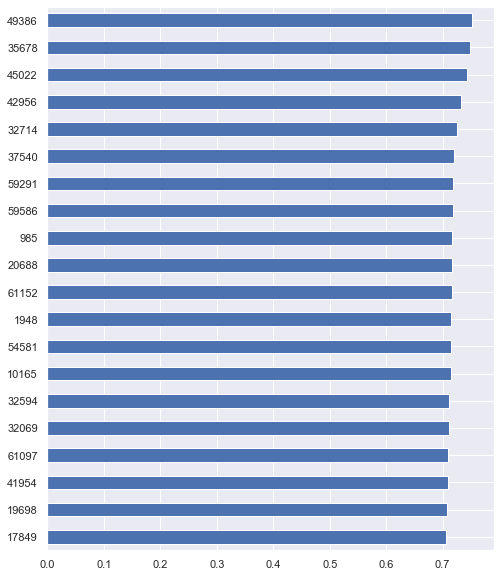

In [91]:
df_pred["cv_mean"] = df_pred.apply(lambda x: np.mean(x), axis=1)
_df = pd.concat([train_df, df_pred], axis=1)
_df["diff"] = _df["y"] - _df["cv_mean"]
_df["diff"] = np.abs(_df["diff"])
_df = _df.sort_values("diff", ascending=True)
#_df = _df.reset_index()
_df = _df.tail(20)
#_df["index"] = _df["index"].astype(str)
display(_df)
#_df["diff"].head(10)#.T.plot()

#plt.figure(figsize=(8, 10))
#sns.barplot(y="index", x="diff", data=_df)
#sns.barplot(x="index", y="diff", data=_df)
#plt.show()

_df["diff"].plot.barh(figsize=(8, 10))
#df_pred[["fold_1", "fold_2"]].plot.scatter(x="fold_1", y="fold_2", figsize=(10, 10))
#df_pred["fold_1"].plot(figsize=(10, 10))

In [92]:
import sys
sys.path.append(r'C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\code')
from util import Util

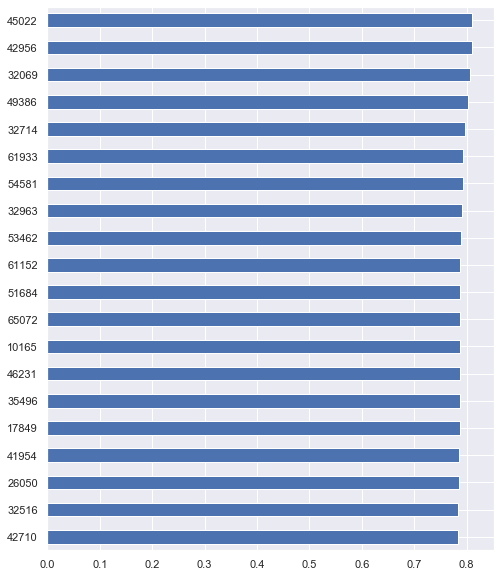

In [96]:
Util.check_y_diff("tmp", 
                  r"C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\code_train\code_eng1_1_csv\train_best_param\train_probas.tsv")

In [1]:
class Submit():

    @staticmethod
    def nelder_mead_th(true_y, pred_y):
        """ネルダーミードでf1スコアから2値分類のbestな閾値見つける"""
        from scipy.optimize import minimize

        def f1_opt(x):
            return -f1_score(true_y, pred_y >= x)

        result = minimize(f1_opt, x0=np.array([0.5]), method="Nelder-Mead")
        best_threshold = result["x"].item()
        return best_threshold


    @staticmethod
    def pred_nelder_mead(pred_dir, out_dir):
        """nelder_meadで決めた閾値でcvの平均値を2値化する"""
        # nelder_meadの学習データ
        df_pred = pd.read_csv(f"{pred_dir}/train_probas.tsv", sep=",")
        train_y = train_df["y"].values
        # cvの平均値
        train_pred_prob = df_pred.apply(lambda x: np.mean(x), axis=1).values

        # 閾値を0.5としたとき
        init_threshold = 0.5
        init_score = f1_score(train_y, train_pred_prob >= init_threshold)
        print("init_threshold, init_score:", init_threshold, init_score)

        # nelder_meadの閾値
        best_threshold = nelder_mead_th(train_y, train_pred_prob)
        best_score = f1_score(train_y, train_pred_prob >= best_threshold)
        print("best_threshold, best_score:", best_threshold, best_score)

        # nelder_meadの閾値で2値化
        df_pred = pd.read_csv(f"{pred_dir}/test_probas.tsv", sep=",")
        test_pred_prob = df_pred.apply(lambda x: np.mean(x), axis=1).values
        test_pred_y = [int(x > best_threshold) for x in test_pred_prob]

        # ファイル出力
        df_test_pred = pd.DataFrame({"y": test_pred_y}).reset_index()
        df_test_pred.columns = ["id", "y"]
        df_test_pred.to_csv(f"{out_dir}/submission_nelder_mead.csv", index=False)
        display(df_test_pred)
    

_DIR = r"C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train"
Submit().pred_nelder_mead(_DIR, _DIR)

NameError: name 'pd' is not defined

In [24]:
_DIR = r"C:\Users\81908\jupyter_notebook\tf_2_work\Probspace_geme_compe\model\train"
df_pred = pd.read_csv(f"{_DIR}/test_probas.tsv", sep=",")
pred_prob = df_pred.apply(lambda x: np.mean(x), axis=1).values
[int(x > 0.49111328125) for x in pred_prob]

[0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,


In [14]:
def nelder_mead_func(trues, preds):
    """
    ネルダーミードで任意の関数のbestな重み見つける
    - func_opt関数の中身変更すること
    - 複数モデルの結果ブレンドするのに使える
    """
    from sklearn.metrics import f1_score
    from scipy.optimize import minimize
    from sklearn.metrics import mean_squared_error

    def func_opt(x):
        # y = a*x1 + b*x2 * c*x3 みたいな式のa,b,cのbest重み最適化
        blend_preds = 0
        for x_i, p_i in zip(x, preds):
            blend_preds += p_i * x_i
        print("p", len(blend_preds))
        print("t", len(trues))
        # 正解との平均2乗誤差返す
        return mean_squared_error(trues, blend_preds)

    result = minimize(func_opt, x0=np.array([1.0 for i in range(preds.shape[1])]), method="Nelder-Mead")
    # print(result)
    best_thresholds = result["x"]
    return best_thresholds

if __name__ == '__main__':
    train_y = train_df["y"].values
    #print(train_y)
    train_pred_probs = df_pred.values
    #print(train_pred_probs)
    
    # y = a*x1 + b*x2 * c*x3 の式のa,b,cのbest重み最適化
    best_thresholds = nelder_mead_func(train_y, train_pred_probs)    
    print("best_thresholds:", best_thresholds)

p 10
t 66105


ValueError: Found input variables with inconsistent numbers of samples: [66105, 10]